# Exploring Bayesian Optimization

In this post, we are going to focus on two tasks, active learning - where we query the user/oracle to label samples; and the multi-arm bandit - where we again query the user/Oracle which returns us a scalar reward. We will be trying to pose the problems first and then talk about some of the ways to solve these problems.

The primary motivation behind active learning is the expensive cost of labeling in machine learning tasks.

## Mining Gold!

Let us explain the two problems using the gold mining application.
We will, for now, look at only one-dimensional locations, i.e., we are talking gold distribution only about a line.
The issue we have is that at the start of the activity, we have no idea about the amount of gold at different locations.
The only way we can get the information about the amount of gold is by drilling at a location.
This drilling is costly and involves expensive sensors to be used.
We, therefore, want to minimize the number of drillings that we require.

We below show two of the common objectives for the gold mining problem.

- **Problem 1: Best Estimate of Gold Distribution**
  In this problem, we are supposed to estimate the amount of gold on the one-dimensional line. But we can not drill at every location. We should drill at those locations that provide us the "maximum" information about the distribution of the gold.
  
- **Problem 2: Location of Maximum Gold**
  In this problem, we are supposed to find the location in the one-dimensional space where the gold quantity is the maximum. This problem focuses on finding the location with the most gold content.


![](MAB_gifs/active-gp.gif)

---

![](MAB_gifs/mab-gp-pi-eps0.5.gif)

- Here are representative animations showing the process of drilling at new locations and to reduce the uncertainty and get the best predictions showcasing the Active Learning problem.

- And drilling at locations to get the location of the maximum gold reserve, showcasing the Multi Armed Bandit problem

We will build the solution to both of these problems from the ground up.

#### Some imports

In [2]:
import os
import warnings
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.special import ndtr
from scipy.stats import norm

warnings.filterwarnings('ignore')
# plt.style.use('classic')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
# plotting styles
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['lines.linewidth']= 2.7
alpha_plt = 0.4 # beautification

# gifs stuff
gifDir = 'MAB_gifs'
os.makedirs(gifDir, exist_ok=True)
delay = 60

#### Prettyfing Matplotlib plots

In [4]:
SPINE_COLOR = 'gray'

def format_axes(ax):
#     for spine in ['top', 'right']:
#         ax.spines[spine].set_visible(False)

#     for spine in ['left', 'bottom']:
#         ax.spines[spine].set_color(SPINE_COLOR)
#         ax.spines[spine].set_linewidth(0.5)

#     ax.xaxis.set_ticks_position('bottom')
#     ax.yaxis.set_ticks_position('left')

#     for axis in [ax.xaxis, ax.yaxis]:
#         axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

### Active Learning

**Problem 1** is very similar to problems we like to solve using active learning. Active learning is used to predict distribution by reducing uncertainty. One of the ways we can reduce the uncertainty is by choosing the point at which we have the maximum variance (we are most uncertain).

### Gaussian Processes

In our previous post, [here](GP-1.html); we had introduced the Gaussian Process. As you can remember, we use Gaussian Processes to get a prediction as well as the attached uncertainty (variance) with that prediction. This will turn out to be useful for us, as we wanted to drill where we were most uncertain. By using Gaussian processes, we take some very naive assumption that the gold distribution of nearby points in similar (smoothness).

#### Creating ground truth data

In [5]:
def f(x):
    """The function to predict."""
    return 2*((x-3)*np.sin((x-3))) + 2 + 0.5*x

Let us now try to see how our groundtruth data looks like.

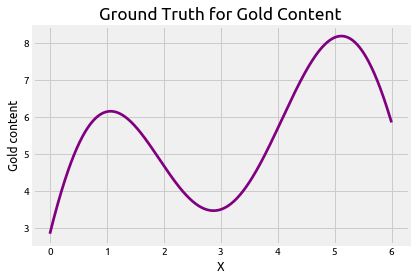

In [6]:
x = np.atleast_2d(np.linspace(0, 6, 600)).T
plt.plot(x, f(x), color='purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.title("Ground Truth for Gold Content")
format_axes(plt.gca())
plt.savefig('MAB_gifs/GT.svg', bbox_inches="tight")

#### Prior Model

Our prior model doesn't know much and assumes a smooth relationship between points via an Matern kernel. The Grey line in the graph below denotes the knowledge we have about the gold content without drilling even at a single location.

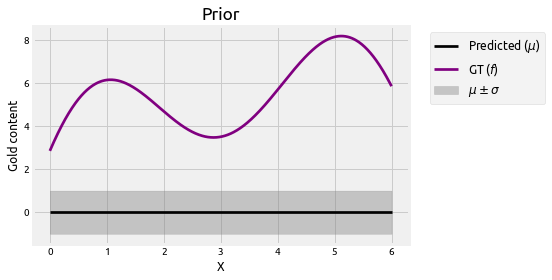

In [7]:
kernel = Matern(length_scale=1.0)
# kernel = None
gp = GaussianProcessRegressor(kernel=kernel)
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted ($\mu$)')
plt.plot(x, f(x), 'purple', label=r'GT ($f$)')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.title("Prior")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma,
                 color='gray', 
                 alpha=alpha_plt, label=r'$\mu \pm \sigma$')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
format_axes(plt.gca())
plt.savefig('MAB_gifs/prior.svg', bbox_inches="tight")

Also, take notice that the confidence (uncertainty) about the gold content is also the same for every location.

####  Adding Training Data
Let us now add a point to the train set or in other words, drill one of the locations and see the gold content (`y`). We can see how our confidence and our estimates change after we get this first information by fitting the model to the new data. I am going to add `(x = 0.5, y = f(0.5))` into the train set now.

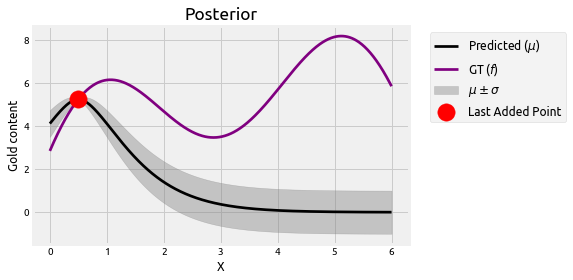

In [8]:
train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()
gp.fit(train_X, train_y)
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label=r'Predicted ($\mu$)')
plt.plot(x, f(x), 'purple', label=r'GT ($f$)')
plt.xlabel("X")
plt.title("Posterior")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=alpha_plt, label=r'$\mu \pm \sigma$')
plt.scatter(train_X, train_y, color='red', s=300, zorder=10, label='Last Added Point')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
format_axes(plt.gca())
plt.savefig('MAB_gifs/posterior.svg', bbox_inches="tight")

Nice! We see now that the posterior has changed and we are very certain about the gold content in the vicinity of `x = 0.5`, but, very uncertain far away from it. Also, we can see that the mean of the point closer to `x = 0.5` is closer to the value that we got from drilling and seeing the gold content. So, we now come to the key idea.

#### Active Learning Procedure

1. Choose the point of having the highest uncertainty
2. Add the point to train set
3. Train on the new train set
4. Go to 1 till convergence or budget elapsed

In [9]:
# Stopping criteria is 10 iterations
for i in range(10):
    # Fit on current train set
    gp.fit(train_X, train_y.flatten())
    # predict on current pool set
    y_pred, sigma = gp.predict(x, return_std=True)
    plt.plot(x, y_pred, 'k', label=r'Predicted ($\mu$)')
    plt.plot(x, f(x), 'purple', label=r'GT ($f$)')
    plt.xlabel("X")
    plt.ylabel("Gold content")
    plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, 
                     color='gray', alpha=alpha_plt, label=r'$\mu \pm \sigma$')
    plt.scatter(train_X[:-1], train_y[:-1], color='black', s=300, zorder=10, label='Train points')
    plt.scatter(train_X[-1], train_y[-1], color='red', s=300, zorder=10, label='Query Point')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(f"Iteration: {i}")
    format_axes(plt.gca())
    plt.ylim((1, 9))
    plt.xlim((-1, 7))
    dirName = 'active-gp-img'
    os.makedirs(dirName, exist_ok=True)
    plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight", dpi=180)
    plt.close()
    
    # Choose the next point with highest sigma
    next_ix = np.argmax(sigma)
    next_x = x[next_ix]
    # Add new point with highest uncertainty to the pool set
    train_X = np.vstack([train_X, [x[next_ix]]])
    train_y = f(train_X)

Let us now automate this process and see how our posterior changes at every iteration where we add a sensor. For each of our iteration below, the prior was the Gaussian Process learned on the points already in the training set. We have recreated the 1st animation at the top of the post!

In [10]:
!convert -delay {delay} -loop 0 active-gp-img/*.png MAB_gifs/active-gp.gif

![](MAB_gifs/active-gp.gif)

There you go we have recreated one of the plots from the starting of the blog! One point to notice is that this idea of choosing the most uncertain location leads to querying of the points that are the farthest (visible when we choose the 2nd location to drill). This might not be so good as we are kind of wasting our drillings because they are at the boundary of the 1-dimensional plot.

----

### Multi-Armed Bandit

**Problem 2** requires us to find the location where the gold content is maximum. Even though the problem setting may be similar, the objective is quite different than problem 1. In other words, we just want the location where we can drill to get the most gold.

Older problem - Earlier in the active learning problem, our motivation for drilling at locations was to predict the distribution of the gold content over all the locations in the one-dimensional line. We, therefore, had chosen the next location to drill where we had maximum uncertainty about our estimate.

In this problem, we are instead interested to know the location at which we find the maximum gold. For getting the location of maximum gold content, we might want to drill at the location where predicted mean is the highest (exploit). But unfortunately our mean is not always accurate, so we need to correct our mean (reduce variance / explore) too. Multi-Arm Bandit looks at both exploitation and exploration, whereas in the case of Active Learning Problem, we only cared about exploration.

#### Acquisition Functions

Now, to take into account the combination of exploration and exploitation, we try to use a function which combines the two sides. These utility functions that take into account both exploration and exploitation in multi-arm bandit problem are called acquisition functions.

In [11]:
class ACQ:
    def acq_fn(self, *args, **kwargs):
        raise NotImplemented
    def __str__(self):
        return self.__class__.__name__
    def __call__(self, *args, **kwargs):
        return self.acq_fn(*args, **kwargs)

class ACQ1(ACQ):
    def acq_fn(self, gp_reg, x, lam = 0.4, **kwrags):
        """
        gp_reg: sklearn.GPRegresssor
        lam: float, where the objective is: \mu(x) + \lambda \sigma(x)
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        return y_pred + lam*sigma

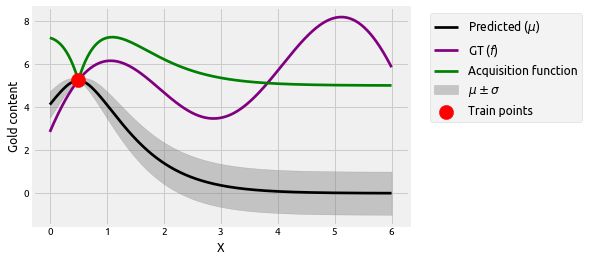

In [12]:
acq_obj = ACQ1()

train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()
gp.fit(train_X, train_y)
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label=r'Predicted ($\mu$)')
plt.plot(x, f(x), 'purple', label=r'GT ($f$)')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, 
                 color='gray', alpha=alpha_plt, label=r'$\mu \pm \sigma$')
plt.scatter(train_X, train_y, color='red', s=200, zorder=10, label='Train points')
plt.plot(x, acq_obj(gp, x, 5), label='Acquisition function', color='green')
format_axes(plt.gca())
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig(f"MAB_gifs/acq_fn.svg", bbox_inches="tight")

Here, we can see that mean near the location of the just added point (red point) is high. But as we go far from the red point, we see that our uncertainty increases to a maximum. As we discussed in multi-arm bandit problem, we like to have some combination of exploration and exploitation. The most basic way to do so is by linearly combining the two values.

### ACQ1

This combined value that takes into account exploration and exploitation is referred to as the acquisition value, returned by acquisition function. We see at around the location `x = 1.4` we get the maximum value for the acquisition (green curve). Thus we next select this location to drill.

The intuition of using the acquisition function `mean + lam * uncertainty` is that we are interested in finding the global mean, so taking into account the estimated mean would be a good idea. Additionally, we would like to explore too (using `lam`); else we might be stuck in a local minimum if don't explore too much (see below).

We define a big plotting function below for saving us the trouble down the road.

In [13]:
def rargmax(b):
    """Randomly tie breaking argmax"""
    return np.random.choice(np.flatnonzero(b == b.max()))

def plot_acquisition(
        train_X, train_y,
        acq_class, acq_params={},
        ylim0=None, xlim0=None,
        ylim1=None, xlim1=None,
        y1scale='linear', it = 10,
        seed = 2
    ):
    """acq_params would contain the parameters for our acq_fn"""
    np.random.seed(seed)
    # for storing the max till it iters
    max_till_now = []
    
    # Stopping criteria is 10 iterations
    for i in range(it):
        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[1].set_yscale(y1scale)
        
        # limits
        ax[0].set_ylim(ylim0) if ylim0 is not None else ax[0].set_ylim(min(f(x)-.5), max(f(x))+.5)
        ax[0].set_xlim(xlim0) if xlim0 is not None else ax[0].set_xlim(min(x)-.5, max(x)+.5)
        ax[1].set_ylim(ylim1) if ylim1 is not None else None
        ax[1].set_xlim(xlim1) if xlim1 is not None else ax[1].set_xlim(min(x)-.5, max(x)+.5)
        
        # fitting
        gp.fit(train_X, train_y.flatten())
        
        # plot Acquisition
        acq_obj = acq_class()
        acquisition = acq_obj(gp, x, t=i+1, **acq_params, mu=max(train_y))
        ax[1].plot(x, acquisition, label='Acquisition function', color='green')
        
        # predict on current pool set
        y_pred, sigma = gp.predict(x, return_std=True)
        ax[0].plot(x, y_pred, 'k', label=r'Predicted ($\mu$)')
        ax[0].plot(x, f(x), 'purple', label=r'GT ($f$)')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Gold content")
        ax[0].fill_between(x.flatten(), y_pred+sigma,
                           y_pred-sigma, color='gray',
                           alpha=alpha_plt, label=r'$\mu \pm \sigma$')
        ax[0].scatter(train_X, train_y, color='black', s=100,
                      zorder=10, label='Train Points')
        ax[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")
        if str(acq_obj) == "PI":
            ax[1].set_ylabel(r'$\alpha_{PI}$')
        elif str(acq_obj) == "EI":
            ax[1].set_ylabel(r'$\alpha_{EI}$')
        elif str(acq_obj) == "GP_UCB":
            ax[1].set_ylabel(r'$\alpha_{GP-UCB}$')
        elif str(acq_obj) == "ACQ1":
            ax[1].set_ylabel(r'$\alpha_{UCB}$')
        elif str(acq_obj) == "Rand":
            ax[1].set_ylabel(r'$\alpha_{Random}$')
        elif str(acq_obj) == "EI_PI":
            ax[1].set_ylabel(r'$\alpha_{EI-PI}$')
        elif str(acq_obj) == "Thompson":
            ax[1].set_ylabel(r'$\alpha_{Thompson}$')
        else:
            raise ValueError
            
        
        if 'eps' in acq_params.keys():
            ax[0].set_title(f"Iteration: {i} \n" + r"$\epsilon$: " + f"{acq_params['eps']}")
            
        elif 'lam' in acq_params.keys():
            ax[0].set_title(f"Iteration: {i} \n" + r"$\lambda$: " + f"{acq_params['lam']}")
        
        elif 'v' in acq_params.keys():
            ax[0].set_title(f"Iteration: {i} \n" + \
                            r"$v$: " + str(acq_params['v']) + '\n' \
                            r"$\delta$: " + str(acq_params['delta']))
        
#         elif 'eps' in acq_params.keys():
#             ax[0].set_title(f"Iteration: {i} \n" + r"$\epsilon$: " + f"{acq_params['eps']}")
        # Choose the next point with highest sigma
        max_mu = max(train_y)
        max_till_now.append(max_mu)
        next_ix = rargmax(acquisition)
        next_x = x[next_ix]

        # Add new point with highest uncertainty to the pool set
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)

        # Add new point with highest uncertainty to the pool set
        ax[1].scatter(x[next_ix], acquisition[next_ix], marker='+',s=50,
                      c='blue', zorder=10, label='Maxima\n(Tie Randomly Broken)')
        ax[1].axvline(x = x[next_ix], color='black', lw=0.6, zorder=7, alpha=1)
        ax[1].axhline(y = acquisition[next_ix], color='black', lw=0.6, zorder=7, alpha=1)
        ax[0].scatter(x[next_ix], f(x[next_ix]), color='red',
                      s=200, zorder=1, label='Query Point')
        ax[0].legend(bbox_to_anchor=(1.1,1), loc="upper left")
        ax[1].legend(bbox_to_anchor=(1.1,0.5), loc="upper left")
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)
        format_axes(ax[0])
        format_axes(ax[1])

        acq_params_str = '-'.join(list(map(str, acq_params.values())))
        dirName = './MAB_pngs/'+str(acq_obj)+'/'+acq_params_str
        os.makedirs(dirName, exist_ok=True)
        plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight", dpi=180)
        plt.close()
    return dirName, max_till_now

In [14]:
train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()

In [15]:
acq_params = {'lam': 1}

dirName, _ = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 10)
)

# gify
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-1.gif

Let us now try different hyperparameters for `ACQ1`. We can see that on increasing `lam` we "explore" more! In the below case we can easily see since we didn't give too much importance to the uncertainty (low `lam`) we got stuck in local minima.

![](MAB_gifs/mab-gp-1.gif)

In [16]:
acq_params = {'lam': 5}

dirName, _ = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 10)
)

# gify
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-5.gif

Below we can see that this choice of `lam = 5` is still a little smaller than we like (we would like to see that we get to exploit the location where the gold is the most.).

![](MAB_gifs/mab-gp-5.gif)

In [17]:
acq_params = {'lam': 10}

dirName, mtn_acq = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 14)
)

!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-10.gif

Perfect! We see that setting this value of `lam = 10` resulted in finding points near the global maxima and not getting stuck in a local maximum.

![](MAB_gifs/mab-gp-10.gif)

---

### Random
We had used a little intelligent acquisition function earlier, let's see is out acquisition function is not that intelligent and chooses randomly.

In [18]:
class Rand(ACQ):
    def acq_fn(
        self, gp_reg, x, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        return np.random.uniform(size=x.shape[0])

In [19]:
dirName, mtn_rand = plot_acquisition(
    train_X, train_y,
    Rand, ylim1=(0, 1.2)
)

# gify
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/rand.gif

We have here implemented a random method as a baseline. Notice, random method can find a location near the global maximum but is not able to exploit (try to find the global maxima that might be near this "best" location). Instead, it randomly chooses to explore (not even intelligently) here and there. Even with no intelligent, we might get good locations which might be close to the location with the most gold content.

![](MAB_gifs/rand.gif)

---

### Probability of Improvement (PI)

Let us look into our next method for the MAB maximisation problem. As before, we want to balance or trade-off between exploration and exploitation. The idea behind the algorithm is fairly simple - choose the next point as the one which has the highest probability of improvement over the current max ($\mu^+$).


Let's understand this concept via two cases:

1. We have two points of similar means (of function values (gold in our case)). We now want to choose one of these to obtain the labels or values. We will choose the one with higher variance. This basically says that given same exploitability, we choose the one with higher exploration value.
2. We have two points having same variance. We would now choose the point with the higher mean. This basically says that given same explorability, we will choose the one with higher exploitation value.


1. Let $\mu^+$ be the current highest value of the function
2. Let $\epsilon$ be close to zero
3. Choose $x^* = arg\,max(P(f(x)) > (\mu^+ +\epsilon))$

This can be given as: $x^* = _{arg\,max_{x}} \Phi(\frac{\mu(x) - \mu^+ - \epsilon}{\sigma(x)})$ where
$\Phi(.)$ indicates the CDF.

In [20]:
# Code is heavily borrowed from: https://modal-python.readthedocs.io/
# en/latest/_modules/modAL/acquisition.html#max_PI
class PI(ACQ):
    def acq_fn(
        self, gp_reg, x, mu=5., eps=0.01, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        cdf = ndtr((y_pred - mu - eps)/sigma)
        return cdf

#### Intuition behind PI

Below is a graph that helps to visualize how the PI values are calculated. We have calculated for 3 points `x in [0.10, 0.6, 4]`. We can see the CDF being shaded in the graphs below. Further, we can see if we increase `eps`, we implicitly place more importance to the uncertainty of a point. If `eps` is increased, the points with a larger sigma will benefit as their probability density is spread more. Thus points with more spread out sigma would have a higher value of cumulative density function on same $\mu^+ + \epsilon$.

In [22]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def pi_cdf_plot(gp, x, train_X, train_y, x_locs, epss=[0.1]):
    '''gp: trained gp
    x: all x pos
    train_X: locations sensed till now
    train_y: sensed functional values
    x_locs: points on x axis we would like to visualize pi values
    '''
    for kk, eps in enumerate(epss):
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(14,10))
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

        # PI Plot
        p = PI()
        gp.fit(train_X, train_y)
        mu_plus = max(train_y) + eps
        ax[0].plot(x, p(gp, x, mu=mu_plus, eps=eps))
        ax[0].set_ylabel(r"$\alpha_{PI}$")
        ax[0].set_xlabel("X");
        ax[0].set_title(r"PI with $\epsilon$: " + f"{eps}")
        colors = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k', 'w'))
        
        for xloc in x_locs:
            ax[0].axvline(x = xloc, color=next(colors), lw=0.6, zorder=7, alpha=1)
        
        colors = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k', 'w'))
        ax[0].set_ylim((0, 1))
        # CDF plot
        # for internal calcs
        y_max = max(f(x))
        y_min = min(f(x))
        # getting correpsonding indices
        locs = []
        for x_loc in x_locs:
            ix = np.argmin(abs(x - x_loc))
            locs.append(ix)

        # plotting GT
        ax[1].plot(x, f(x), color='purple', label=r'GT ($f$)')
        # plotting preds
        mu, sig = gp.predict(x, return_std=True)
        ax[1].plot(x, mu, color='black', label=r'Predictions ($\mu$)')
        ax[1].fill_between(x.flatten(), 
                           mu + sig, mu - sig, 
                           color='black', 
                           alpha=alpha_plt,
                           label=r'$\mu \pm \sigma$')
        # plotting mu_plus
        ax[1].plot(x, len(x)*[mu_plus], '-.b',
                 label=r'Max Detected $(f(x^+))$')

        gran = 1000
        y_linspace = np.linspace(-1, 9, gran)

        # finding where y_linspace meets mu_plus
        mu_plus_ix = np.argmin(abs(y_linspace - mu_plus))

        for i, loc in enumerate(locs):
            color = next(colors)
            x_linspace = gaussian(y_linspace, mu[loc], sig[loc]) + x[loc]
            ax[1].plot(x_linspace, y_linspace, 
                       color=color, alpha=0.8,
                       label=f'Gaussian PDF for {i}th Location')
            mu_line = np.array([mu_plus] * (gran - mu_plus_ix))
            ax[1].fill_between(x_linspace[mu_plus_ix:],
                             y_linspace[mu_plus_ix:],
                             mu_line, color=color, alpha=alpha_plt)

        ax[1].set_xlabel("X Positions")
        ax[1].set_ylabel("Gold Content")
        ax[1].set_title("CDF (Shaded regions) for selected points")
        ax[1].legend(loc='right')
        format_axes(ax[0])
        format_axes(ax[1])
        dirName = 'MAB_pngs/pi_cdf'
        os.makedirs(dirName, exist_ok=True)
        plt.savefig(f"{dirName}/{kk}.png", bbox_inches="tight", dpi=180)
        plt.close()

In [23]:
pi_cdf_plot(gp, x, train_X, train_y,
            x_locs=[0.10, 0.6, 4], 
            epss=[0, 0.1, 0.4, 0.8])

!convert -delay {delay} -loop 0 MAB_pngs/pi_cdf/*.png {gifDir}/pi_cdf.gif

![](MAB_gifs/pi_cdf.gif)

`mu_plus` refers to the maximum functional value i.e., `max(train_y)`, where `train_y` refers to the gold content at the currently drilled locations. We see that the probability of improvement values are calculated by finding the functional value of the cumulative density function at `mu_plus`. The Gaussian parameters for each point are the mean and standard deviation predicted from Gaussian Process Regressor for that point.

#### Hyperparameter: Eps
Now we have the intuition behind how Probability of Improvement is calculated, now let's change `eps` and look at its effects.

In [24]:
eps = 0.01
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    PI, ylim1=((-.05, 1.05)),
    acq_params = acq_params
)

# gify
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-pi-eps{eps}.gif

![](MAB_gifs/mab-gp-pi-eps0.01.gif)

Looking at the graph above we can see that we are not effectively exploring at value `eps = 0.01` for the Probability of Improvement acquisition function. We are stuck.

In [25]:
eps = 1
acq_params = {
    'eps': eps
}

dirName, mtn_pi = plot_acquisition(
    train_X, train_y,
    PI, ylim1=((-.05, .1)),
    acq_params = acq_params,
    y1scale='log'
)

# gify
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-pi-eps0.5.gif

![](MAB_gifs/mab-gp-pi-eps0.5.gif)

Looking above, we see increasing the value to `eps = 0.5` enables us to explore more and get to the maximum value which we wanted in the case of Multi-arm bandit problem. One can notice that values at $x \in [3, 4.5]$ posses uncertainty (can be identified by the grey translucent area, but as we remember we are not interested in getting the best prediction of the gold distribution, we only care about the maximum value that we can achieve, which this acquisition function with given hyper-parameters is able to capture nicely!

Let's look at what happens if we increase the hyper-parameter `eps` a bit more.

In [26]:
eps = 8
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    PI, ylim1=((-.05, 1.05)),
    y1scale='log', acq_params = acq_params
)

# gify
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-pi-eps3.gif

![](MAB_gifs/mab-gp-pi-eps3.gif)

We see that we made things worse! Our model now uses `eps = 3` which has effectively resulted in way too much exploratoration. This amount of exploration is not able to exploit when we land somewhere near a global maximum.

----

### Expected Improvement (EI)

Probability of improvement only looked at `how likely` is an improvement, but, shouldn't we be looking into `how much` we can improve. The next criterion called Expected Improvement (EI). It looks into both :)

\begin{equation}
    EI(x)=
    \begin{cases}
      (\mu(x) - \mu^+ - \epsilon)\Phi(Z) + \sigma(x)\phi(Z), & \text{if}\ \sigma(x) > 0 \\
      0 & \text{if}\ \sigma(x) = 0 
    \end{cases}
  \end{equation}
 $$Z= \frac{\mu(x) - \mu^+ - \epsilon}{\sigma(x)}$$
 where $\Phi(.)$ indicates CDF and $\phi(.)$ indicates pdf
 

We can see when our _Expected Improvement_ will be high.

- It is high when the expected value of mean(x) - $\mu^+$ is high.
- It is high when the uncertainty around a point is high.

Now, if we see the role of $\epsilon$ in _Expected Improvement_, it is the exact same as the role played in the case of _Probability of Improvement_ (we have the same expression in PI). -- footnotes You can know more about EI from here (https://thuijskens.github.io/2016/12/29/bayesian-optimisation/)

In [27]:
class EI(ACQ):
    def acq_fn(self, gp_reg, x, mu=5., eps=0.01, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        mu: max value of y among the selected train_pts
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        z = (y_pred - mu - eps)/sigma
        return (y_pred - mu - eps)*ndtr(z) + sigma*norm.pdf(z)

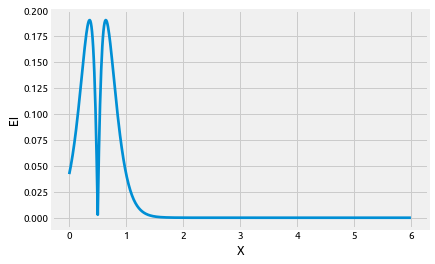

In [28]:
p = EI()
gp.fit(train_X, train_y)
mu_plus = max(train_y)
plt.plot(x, 5*p(gp, x, mu=mu_plus, eps=0))
plt.ylabel(f"{p}")
plt.xlabel("X");

In [29]:
eps = 0.01
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    EI, ylim1=((-0.001, .05)),
    acq_params=acq_params,
    y1scale='log'
)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei-eps{eps}.gif

![](MAB_gifs/mab-gp-ei-eps0.01.gif)

Like the Probability of Improvement's acquisition function, we can moderate the amount of explorability the Expected Improvement's acquisition function by setting the `eps` hyper-parameter. 

We see that having `eps = 0.01` primarily results in exploitation, and we are not able to get to the global maxima due to this myopic drilling location selection.

Let's try increasing the `eps` variable to focus a little more on exploribility.

In [30]:
eps = 1.5
acq_params = {
    'eps': eps
}

dirName, mtn_ei = plot_acquisition(
    train_X, train_y,
    EI, ylim1=((-0.001, .05)),
    acq_params=acq_params,
    y1scale='log'
)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei-eps{eps}.gif

![](MAB_gifs/mab-gp-ei-eps1.5.gif)

As we expected, increasing the value to `eps = 1.5` makes the acquisition function explore more and exploit when the time comes. We see that it moves slowly once it reaches near the global maxima, trying to find the global maxima. In this case, the exploration is effectively helping us reach a higher functional value much earlier!

Let's see if increasing `eps` helps us more!

In [31]:
eps = 3
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    EI, ylim1=((-0.001, .05)),
    acq_params=acq_params,
    y1scale='log'
)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei-eps{eps}.gif

![](MAB_gifs/mab-gp-ei-eps3.gif)

Is this better than before? Turns out a yes and a no. We see that here we do too much exploration given the value of `eps = 3`. Which results in early reaching something close to global maxima, but unfortunately we don't exploit to get more gains near the global maxima. We would have liked an acquisition function that tried to exploit a bit more after reaching somewhere close to the global maxima. In essence:
- reach near global maxima in a lower number of iterations
- we don't exploit once we reach near global maxima

---

In [108]:
def ei_pi_plot(
        train_X, train_y, i,
        ylim=None, xlim=None,
        yscale='log', xscale='log',
        seed = 2,
        pi_params={}, ei_params={},
    ):
    np.random.seed(seed)
    
    fig, ax = plt.subplots()
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)

    # fitting
    gp.fit(train_X, train_y.flatten())

    # for plotting scatter plot
    pi_obj = PI()
    ei_obj = EI()
    pi_acq = pi_obj(gp, x, **pi_params, mu=max(train_y))
    ei_acq = ei_obj(gp, x, **ei_params, mu=max(train_y))
    
    # predict on current pool set
    y_pred, sigma = gp.predict(x, return_std=True)
    ax.scatter(pi_acq, ei_acq, color='black', alpha=0.4, label='Location')
    ax.set_ylabel(r'$\alpha_{EI}$')
    ax.set_xlabel(r'$\alpha_{PI}$')
    
    # limits
    ax.set_ylim(ylim) if ylim is not None else None # ax.set_ylim(min(ei_acq), max(ei_acq)
    ax.set_xlim(xlim) if xlim is not None else None # ax.set_xlim(min(pi_acq), max(pi_acq))
    
    ax.set_title(r'$\epsilon_{PI}$' + str(pi_params['eps']) + '\n' \
                 r'$\epsilon_{EI}$' + str(ei_params['eps']))

    ax.legend(bbox_to_anchor=(1.1,1), loc="upper left")
    format_axes(ax)
    
    pii = list(map(str, pi_params.values()))
    eii = list(map(str, ei_params.values()))
    params_str = '-'.join(pii + eii)
    dirName = './MAB_gifs/Ei_Pi_graph/'
    os.makedirs(dirName, exist_ok=True)
    plt.savefig(f"{dirName}/{i}.svg", bbox_inches="tight")
    plt.close()
    return (dirName)

In [109]:
pi_eps = [0.01]#, 0.001, 0.01, 0.1, 1]
ei_eps = [0.01]#, 0.001, 0.01, 0.1, 1]

for i, (pi_ep, ei_ep) in enumerate(zip(pi_eps, ei_eps)):
    pi_params = {'eps': pi_ep}
    ei_params = {'eps': ei_ep}

    dirName = ei_pi_plot(
        train_X, train_y, i,
        pi_params = pi_params,
        ei_params = ei_params,
        yscale='linear', xscale='linear',
        ylim=(0, 0.05), xlim=(0, .5),
    )

# gify!
# !convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/ei_pi_graph.gif

We have seen two closely related methods, The _Probability of Improvement_ and the _Expected Improvement_. We can think of these two to be related to the ideas that we commonly are familiar with `risk` and `gain` respectively.

It seems natural to see how these metrics change for each of the points. We have plotted the values for both policies' acquisition function's values below, for each of the possible locations. The graph shows the relation followed between EI and PI for when we have a single training point `(0.5 f(0.5))`. 

![](MAB_gifs/Ei_Pi_graph/0.svg)

If we look closely, we can see if we have an equal estimated improvement as in the case with the points with `EI(x) = 0.4` it would be more beneficial to differentiate between these points which have a better value for Probability of Improvement. In other words, when `gain`s are the same, we should prioritize to choose the option with lesser `risk`. And similarly, when the `risk`s are similar, we would likely want to go with points with greater `gain`s.

---

### Gaussian Process Upper Confidence Bound (GP_UCB)

GP_UCB is another formulation for acquisition function where we also have theoretical bounds on the number of iterations taken to reach near global maximum.

In [110]:
class GP_UCB(ACQ):
    def acq_fn(self, gp_reg, x, t, mu=5.,
               v = 1., delta=1., **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        t: Iteration number (1, ..)
        """
        d = x.shape[1]
        y_pred, sigma = gp_reg.predict(x, return_std=True)  
#         print (y_pred, sigma)
#         print ('blah', np.log( (t**(d/2. + 2))*(np.pi**2)/(3. * delta)  ))
#         print ('v3', v* (2*  np.log( (t**(d/2. + 2))*(np.pi**2)/(3. * delta)  )))
        k = np.sqrt( v* (2*  np.log( (t**(d/2. + 2))*(np.pi**2)/(3. * delta)  )))
#         print ('k', k)
        return y_pred + k*sigma

In [111]:
acq_params = {
    'v': 1,
    'delta': 1
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    GP_UCB, ylim1=((0, 10)),
    acq_params=acq_params,
)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-gp_ucb1-1.gif

![](MAB_gifs/mab-gp-gp_ucb1-1.gif)

We seem to be exploiting too much , let's increase the exploratory hyperparameters!

In [112]:
acq_params = {
    'v': 3,
    'delta': 1
}

dirName, mtn_gp_ucb = plot_acquisition(
    train_X, train_y,
    GP_UCB, ylim1=((0, 10)),
    acq_params=acq_params,
)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-gp_ucb3-1.gif

![](MAB_gifs/mab-gp-gp_ucb3-1.gif)

Using this set of hyper-parameters, we are able to get near global maxima and further "exploit" to find the global maximum. This was a result of increasing the value of `v` to `3`; this shows that `v` gives weightage to exploration.

In [113]:
acq_params = {
    'v': 1,
    'delta': 3
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    GP_UCB, ylim1=((0, 10)),
    acq_params=acq_params,
)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-gp_ucb1-3.gif

![](MAB_gifs/mab-gp-gp_ucb1-3.gif)

Setting the values of the hyperparameters  to `v = 1` and `delta = 3` results a greater exploitation.

---

### Thompson Sampling
One more acquisition function that is quite common is Thompson Sampling. It has a low overhead of setting up.

The idea is to sample functions within upper and lower probabilistic bounds of a regressor; one can then optimize on these functions and chose the next query point to be the $\boldsymbol{x} = argmax(\texttt{sampled_f})$. In other words, sampling functions within the greyed out area in the graph below.

![](MAB_gifs/posterior.svg)

Thompson Sampling is general enough to be useful even when we have Bernoulli (the domain of x is spatially independent) distributions modeling the function $F$, instead of Gaussian Process.

In [114]:
class Thompson(ACQ):
    def acq_fn(self, gp_reg, x, mu=5., eps=0.01, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        mu: max value of y among the selected train_pts
        x: domain in which we are optimizing
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        sampled_y = gp_reg.sample_y(x)
#         plt.plot(x, sampled_y, color='purple')
#         plt.show()
        return sampled_y

In [115]:
dirName, _ = plot_acquisition(
    train_X, train_y,
    Thompson, ylim1=((0, 8)),
    acq_params={'eps':0.01}
)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-thomp.gif

![](MAB_gifs/mab-gp-thomp.gif)

---

### Probability of Improvement + $\lambda \  \times$ Expected Improvement (EI_PI)

Below we have tried to combine PI and EI using a linear combination as a combination of various acquisition function also results in an acquisition function. We can, therefore, combine any of the acquisition function and form a new one.

In [116]:
class EI_PI(ACQ):
    def acq_fn(self, gp_reg, x, mu=5., eps_pi=0.01, eps_ei=0.01, lam=.3, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        
        # ei
        z = (y_pred - mu - eps_ei)/sigma
        ei_acq = (y_pred - mu - eps_ei)*ndtr(z) + sigma*norm.pdf(z)
        
        # pi
        pi_acq = ndtr((y_pred - mu - eps_pi)/sigma)
        return pi_acq + lam * ei_acq

In [117]:
acq_params = {
    'eps_pi': .2,
    'eps_ei': .4,
    'lam': 1,
}

dirName, mtn_ei_pi = plot_acquisition(
    train_X, train_y,
    EI_PI, ylim1=((0, 10)),
    acq_params=acq_params,
    y1scale='log',
)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei_pi.gif

![](MAB_gifs/mab-gp-ei_pi.gif)

### Comparison

Below we have a graph showing a comparison between the methods discussed above. We have chosen the hyper-parameters that gave us the best performance during our basic hyper-parameter search.

We see the _Random_ method is able to find the maximum much before any of the other methods, this can be seen when we are faced with smaller spaces to find the global maximum. If we have more dimensions to `x`, searching in this space would not be so easy using random, due to what we call the curse of dimensionality.

In [118]:
# http://www.johndcook.com/blog/standard_deviation/
# https://github.com/joschu/modular_rl/blob/master/modular_rl/running_stat.py

class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)
    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM)/self._n
            self._S[...] = self._S + (x - oldM)*(x - self._M)
    @property
    def n(self):
        return self._n
    @property
    def mean(self):
        return self._M
    @property
    def var(self):
        return self._S/(self._n - 1) if self._n > 1 else np.square(self._M)
    @property
    def std(self):
        return np.sqrt(self.var)
    @property
    def shape(self):
        return self._M.shape

In [119]:
stats = RunningStat(10)
for seed in range(10):
    dirName, temp = plot_acquisition(
        train_X, train_y,
        Rand, ylim1=(0, 1.2),
        seed=seed
    )
    stats.push(temp)

mtn_rand = stats.mean
rand_sig = stats.std

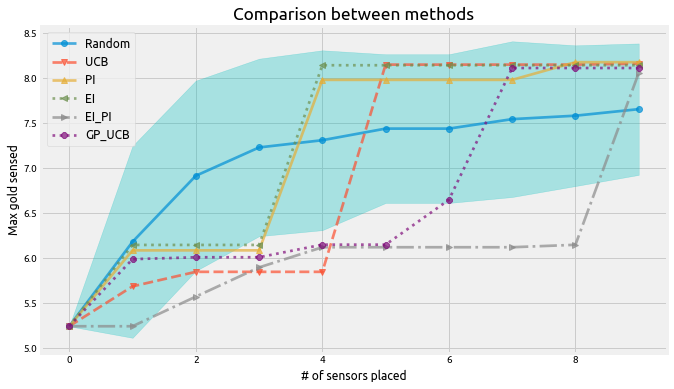

In [120]:
mtns = [mtn_rand, mtn_acq, mtn_pi, mtn_ei, mtn_ei_pi, mtn_gp_ucb]
names = ['Random', 'UCB', 'PI', 'EI', 'EI_PI', 'GP_UCB']
markers = ['o-', 'v--', '^-', '<:', '>-.', '8:']

xx = range(len(mtns[0]))
plt.figure(figsize=(10, 6))
for n, m, mm in zip(names, mtns, markers):
    plt.plot(xx, m, mm, label=n, alpha=0.7)

plt.fill_between(range(10), mtn_rand + rand_sig,
                 mtn_rand - rand_sig, 
                 color='c', alpha=0.3)

plt.legend()
plt.xlabel('# of sensors placed')
plt.ylabel('Max gold sensed')
plt.title('Comparison between methods')
format_axes(plt.gca())
plt.savefig("MAB_gifs/comp.svg", bbox_inches="tight")
plt.show()

![](MAB_gifs/comp.svg)

## Observation

We see that the plots above show the maximum gold content detected for the case of multi-arm bandit problem vs. the number of holes drilled. Looking at the graph above we can see that for our problem Probability of Improvement performed the best among all the variants of Acquisition functions.

# Generalization
Let us now formally introduce Bayesian Optimization. Our goal is to find the $\boldsymbol{x}$ where we reached global maximum (or minimum) of a function $F: \mathbb{R}^d \texttt{ -> } \mathbb{R}$. Constraints in Bayesian Optimization look like below. -- footnotes Slides link to Peter Fraizer

> We’d like to optimize $F: \mathbb{R}^d \texttt{ -> } \mathbb{R}$,
where $d < 20$.<br>
>
>• $F$’s feasible set $A$ is simple,
e.g., box constraints.<br>
• $F$ is continuous but lacks special structure,
e.g., concavity, that would make it easy to optimize.<br>
• $F$ is derivative-free:
evaluations do not give gradient information.<br>
• $F$ is expensive to evaluate:
the # of times we can evaluate it
is severely limited.<br>
• $F$ may be noisy. If noise is present, we’ll assume it
is independent and normally distributed, with
common but unknown variance.<br>

Let us link the above constraints to our initial problem statement of gold mining.

- Our domain in the gold mining problem is a single dimensional box constraint of $0 \leq x \leq 6$.
- Our ground truth can be seen as _not_ convex or concave function, which resulted in local minima as well.
- Our evaluation (by drilling) of the amount of gold content at a location didn't give us any gradient information.
- The function we used in the case of Gold Mining problem is extremely costly to evaluate (drilling costs millions).
- This constraint is still satisfied in our case as we had used 0 noise, or zero mean zero std gaussian noise.

# Higher Dimensions

For now we have been looking at real-valued single dimensional function, i.e. $f: \mathbb{R} \texttt{ -> } \mathbb{R}$ data where we needed to find the value of $\boldsymbol{x}$ where we reached global maximum. Let's move on and try to tackle real-valued functions of $n$ real variables functions, i.e. $f: \mathbb{R}^n \texttt{ -> } \mathbb{R}$. We will soon see that our methods that we saw earlier for the single dimensional case can be easily ported to multi-variable functions.

## Why is this easier?
One valid question one might come up is that we have replaced the original optimization problem to another optimization problem (optimization of acquisition function). How is this any better than the last problem. The main reason is that evaluating the acquisition function is much cheaper, whereas in the original problem, evaluating the value at a particular was extremely costly.

## Bayesian Optimization vs. Gradient Descent
Some of the main differences between BO and GD --cite BOvsGD as pointed out at StackExchange:
 - The biggest difference between Bayesian Optimization and Gradient Descent is that in the latter case, we have access to the gradient values.
 - BO doesn't assume the function to be convex, in the case of Gradient Descent if you would like to get to the global minima, your function should be convex.
 - BO assumes the function we are optimizing is fairly smooth.
 - BO doesn't scale well with large data, as the GP inference is cubic in the number of points.
 
Now, as we have described BO more technically, let's have a look at how we can use this method in the case of Hyperparameter Tuning. Hyperparameters, you ask?

## Hyperparameters v/s Parameters

We all are familiar with Machine Learning and the models that we use. To show one of the use cases for Bayesian optimization, we will quickly differentiate between hyperparameters and parameters. 

Hyperparameters is a parameter whose value is set before the learning process begins. Parameters, on the other hand, are the parameters that are learned looking at the data. One small example that we can think of can be of linear regression, we don't really have hyperparameters, but the parameters are the $W$: weight, $c$: intercept, which is learned from the data. If we apply lasso to linear regression, we introduce a regularization hyperparameter $\lambda$. -- footnotes Wikipedia article

## Hyperparameter Search

Now as we are clear on the difference between hyperparameters and parameters we would like to introduce one of the most common use case of Bayesian Optimization; _Hyperparameter Tuning_: finding best performing hyperparameters on machine learning models. At last, hyperparameter searching is an optimization problem (optimizing our score).

Usually, when training a model isn't expensive and time-consuming, we might just do a grid search or random search. The main issues faced when using these methods are as follows:

- Grid Search is not feasible if getting the functional value is extremely costly, as in case of a large neural network that takes days to train. This might result in days of waiting to get the accuracy scores.
- Random and Grid Search are near brute-force methods; this causes these methods to become extremely inefficient and impossible to use when the dimensions of our search space increase (aka the curse of dimensionality). You can get the intuition for _the curse of dimentionality_ from [this](https://stats.stackexchange.com/a/169170) excellent answer on stackoverflow.com
  > in essence when you have more dimensions you need exponentially more samples to be able to estimate the real-valued multivariable function.

We turn to Bayesian optimization to find counter the expensiveness of getting the functional values, and these increased dimensions.

### Example 1

Let's us use a SVM on sklearn's moons dataset and try to find the optimal hyperparameter using bayesian optimization. Let's have a look at the dataset first.

In [43]:
from sklearn.datasets import make_moons
from sklearn.svm import SVC
import matplotlib as mpl
from sklearn.model_selection import train_test_split

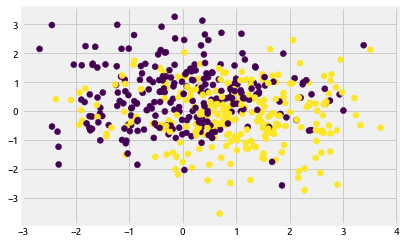

In [44]:
seed = 0
X, y = make_moons(n_samples=500, shuffle=True, noise=1, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

plt.scatter(X[:, 0], X[:, 1], c = y)
plt.savefig("MAB_gifs/moons.svg", bbox_inches="tight")
plt.show()

In [45]:
def f(Listofpoints):
    '''Given a grid of hyperparameters we fit the SVM and return
    the negative of validation error (we are aiming to minimize error)'''
    Listofpoints = np.array(Listofpoints)
    Gammas, Cs = Listofpoints[:, 0], Listofpoints[:, 1]
    Gammas = np.array(Gammas)
    Cs = np.array(Cs)
    shpe = Gammas.shape
    assert (Gammas.shape == Cs.shape)
    accs = []
    for gamma, C in zip(Gammas.flatten(), Cs.flatten()):
        clf = SVC(gamma=gamma, C=C, random_state=seed)
        clf.fit(X_train, y_train)
        pred_y = clf.predict(X_test)
        mask = (pred_y == y_test)
        acc = mask.sum()/mask.shape[0]
        accs.append(acc)
    return np.array(accs).reshape(shpe)

In [46]:
x0 = np.linspace(0.01, 10, 25) # gammas
x1 = np.linspace(0.01, 10, 25) # Cs

x = np.array(list(itertools.product(x0, x1)))
print ('x.shape:', x.shape)

X0, X1 = np.meshgrid(x0, x1)
xx = np.vstack([X0.reshape(X0.size), X1.reshape(X1.size)]).T

GT = f(x)
GT = GT.reshape(X0.shape)
print('GT.shape:', GT.shape)

x.shape: (625, 2)
GT.shape: (25, 25)


In [47]:
kernel = Matern(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel)

In [48]:
# getting one training sample
train_X = np.array([[5, 5]]) # gamma = 5, C = 10
train_y = f(train_X)
print(train_X, train_y)

[[5 5]] [0.6]


In [49]:
def getPoints(a, b):
    '''Returns points in meshgrid'''
    pts = np.concatenate([a.flatten().reshape(-1, 1), 
                          b.flatten().reshape(-1, 1)], 
                         axis=1)
    return pts

In [50]:
def plot_acquisition3d(
        train_X, train_y,
        acq_class, acq_params={},
        z0lim = (0.5, 1),
        it = 10, seed = 0, levels=30, drawedges=True,
        set_z1lim=True,
    ):
    """acq_params would contain the parameters for our acq_fn"""
    np.random.seed(seed)
    # for storing the max till it iters
    max_till_now = []
    max_ix = np.argmax(GT.flatten())
    max_x = X0.flatten()[max_ix], X1.flatten()[max_ix]
    
    # Stopping criteria is 10 iterations
    for i in range(it):
        fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
        for a in ax:
            a.set_aspect('equal')
        
        ax[0].set_ylim((0), max(x[:, 1])) # C
        ax[0].set_xlim((0), max(x[:, 0])) # gamma
        ax[1].set_ylim((0), max(x[:, 1]))
        ax[1].set_xlim((0), max(x[:, 0]))
        
        # fitting
        gp.fit(train_X, train_y.flatten())
        
        # plot ground truth
        boun0 = np.linspace(*z0lim, levels)
        h = ax[0].contourf(X0, X1, GT, cmap='plasma', 
                           levels=levels, 
                           vmin=z0lim[0], 
                           vmax=z0lim[1])
        m = plt.cm.ScalarMappable(cmap='plasma')
        m.set_array(GT)
        m.set_clim(*z0lim)
        plt.colorbar(m, drawedges=drawedges, boundaries=boun0, ax=ax[0])
        # plot current training set
        ax[0].scatter(train_X[:, 0], train_X[:, 1], color='white', s=30,
                      zorder=10, label='Train points')
        # plot the global maxima
        ax[0].scatter(*max_x, marker="*", color='yellow', s=60, zorder=20, label="Gobal Maxima")
        
        # plot Acquisition
        acq_obj = acq_class()
        acquisition = acq_obj(gp, xx, t=i+1, **acq_params, mu=max(train_y))
        if i == 0:
            if set_z1lim:
                z1lim = (min(acquisition), max(acquisition))
                boun2 = np.linspace(*z1lim, levels)
            else:
                z1lim = (None, None)
                boun2 = None
        h2 = ax[1].contourf(X0, X1, 
                            acquisition.reshape(X0.shape), 
                            cmap='plasma', 
                            levels=levels, 
                            vmin=z1lim[0],
                            vmax=z1lim[1])
        if set_z1lim:
            h2 = plt.cm.ScalarMappable(cmap='plasma')
            h2.set_array(acquisition.reshape(X0.shape))
            h2.set_clim(*z1lim)
        plt.colorbar(h2, drawedges=drawedges, boundaries=boun2, ax=ax[1])      
        
        if str(acq_obj) == "PI":
            ax[1].set_title(r'$\alpha_{PI}$' + f"\nIteration: {i} \n" + \
                             r"$\epsilon$: " + str(acq_params['eps']))
        elif str(acq_obj) == "EI":
            ax[1].set_title(r'$\alpha_{EI}$' + f"\nIteration: {i} \n" + \
                             r"$\epsilon$: " + str(acq_params['eps']))
        elif str(acq_obj) == "GP_UCB":
            ax[1].set_title(r'$\alpha_{GP-UCB}$' + f"\nIteration: {i} \n" + \
                            r"$v$: " + str(acq_params['v']) + '\n' \
                            r"$\delta$: " + str(acq_params['delta']))
        elif str(acq_obj) == "Rand":
            ax[1].set_title(r'$\alpha_{Random}$' + f"\nIteration: {i}")
        else:
            raise ValueError
        ax[1].set_xlabel(r"$gamma$")
        ax[1].set_ylabel(r"$C$")
        
        # Choose the next point with highest acq
        max_mu = max(train_y.flatten())
        max_till_now.append(max_mu)
#         print(acquisition)
        next_ix = rargmax(acquisition.flatten())
        n_x = X0.flatten()[next_ix], X1.flatten()[next_ix]
        

        # Add new point with highest uncertainty to the pool set
        train_X = np.vstack([train_X, [*n_x]])
        train_y = f(train_X)

        # Add new point with highest uncertainty to the pool set
        ax[1].scatter(*n_x, marker='X',s=50,
                      c='grey', zorder=10,
                      label='maxima (tie randomly broken)')
        ax[0].scatter(*n_x, color='grey',
                      s=200, zorder=1, label='Query Point')
        ax[0].axvline(n_x[0], color='black', lw=1, zorder=1)
        ax[0].axhline(n_x[1], color='black', lw=1, zorder=1)
        ax[1].axvline(n_x[0], color='black', lw=1, zorder=1)
        ax[1].axhline(n_x[1], color='black', lw=1, zorder=1)
        ax[0].set_xlabel(r"$gamma$")
        ax[0].set_ylabel(r"$C$")
        ax[0].set_title("Ground Truth Accuracies")
        ax[0].legend(bbox_to_anchor=(0,1), loc="upper left", framealpha=0.3)
        ax[1].legend(bbox_to_anchor=(0,1), loc="upper left", framealpha=0.3)

        acq_params_str = '-'.join(list(map(str, acq_params.values())))
        dirName = './MAB_pngs/'+str(acq_obj)+'3d/'+acq_params_str
        os.makedirs(dirName, exist_ok=True)
        plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight", dpi=180)
        plt.close()
    return dirName, max_till_now, train_X

Let us now show the some plots showing Bayesian Optimization for learning nice hyperparameters for our Support Vector Machine model. -- footnotes Note: the surface plots you see for the ground truth accuracies were calculated for each possible of hyperparameter for showcasing purposes.

In [51]:
eps = .001
acq_params = {'eps':eps}
dirName, mtn_pi, _ = plot_acquisition3d(train_X, train_y, 
                                        PI, acq_params=acq_params,
                                        z0lim=(.40, .85),
                                        it=10, levels=40,
                                        set_z1lim=False)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/pi3d-0.05-mat.gif

![](MAB_gifs/pi3d-0.05-mat.gif)

Above we see a gif showing the work of teh _Probability of Improvement_ acquisition function in finding the best hyperparameters.

In [52]:
eps = .001
acq_params = {'eps':eps}
dirName, mtn_ei, _ = plot_acquisition3d(train_X, train_y, 
                                        EI, acq_params=acq_params,
                                        z0lim=(.40, .85),
                                        it=10, levels=40,
set_z1lim=False)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/ei3d-0.0001-mat.gif

![](MAB_gifs/ei3d-0.0001-mat.gif)

Above we see a gif showing the work of teh _Expected Improvement_ acquisition function in finding the best hyperparameters.

In [53]:
v = 0.5
delta = 2
acq_params = {
    'v':v,
    'delta':delta
}

dirName, mtn_gp_ucb, _ = plot_acquisition3d(train_X, train_y, 
                   GP_UCB, acq_params=acq_params,
                   z0lim=(.40, .85),
                   it=10, levels=40, set_z1lim=False)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/gp3d-1-2-mat.gif

![](MAB_gifs/gp3d-1-2-mat.gif)

Above we see a gif showing the work of the _Guassian Processes Upper Confidence Bound_ acquisition function in finding the best hyperparameters. This by far seems to perform the best with getting quite close to the global optimum value of hyperparameters (found using brute force).

In [54]:
stats = RunningStat(10)
for seed in range(10):
    dirName, temp, _ = plot_acquisition3d(
        train_X, train_y, 
        Rand, acq_params=acq_params,
        z0lim=(.40, .85),
        it=10, levels=40,
        seed=seed
    )
    stats.push(temp)

mtn_rand = stats.mean
rand_sig = stats.std

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/rand3d.gif

![](MAB_gifs/rand3d.gif)

Now our favourite random acquisition function. :)

In [55]:
max_f = np.max(GT.flatten())
globalopt = [max_f] * len(mtn_rand)

mtns = [mtn_rand, globalopt, mtn_pi, mtn_ei, mtn_gp_ucb]
names = ['Random', 'GlobalOpt', 'Probability of Improvement', 'Expected Improvement', 'GP_UCB']
markers = ['o-', '*:', 'v--', '>-.', '<:']

xx = range(len(mtns[0]))
plt.figure(figsize=(14, 8))
for n, m, mm in zip(names, mtns, markers):
    plt.plot(xx, m, mm, label=n, alpha=0.7)

plt.fill_between(range(10), mtn_rand + rand_sig,
                 mtn_rand - rand_sig, 
                 color='c', alpha=0.3)
plt.legend()
plt.xlabel('# of Hyper-Parameters Tested')
plt.ylabel('Max Accuracy Reached')
plt.title('Comparison between methods vs Global Optimum')
format_axes(plt.gca())
plt.savefig("MAB_gifs/comp3d.svg", bbox_inches="tight")
plt.close()

![](MAB_gifs/comp3d.svg)

We see GP-UCB performed the best in this case. Random that was performing really nice in the last single dimensional example seems to perform much badly in this case. This can be attributed to the increase in the number of dimensions, it's much difficult to get to the optimal value by using random search.

### Example 2

Let's train CNNs on Mnist. Here we will be using `scikit-optim`, which also provides us support for optimizing our function on a mix of categorical, integral, and real variables. We won't be plotting the ground truth here, as it's extremely costly to do so.

In [56]:
# getting the data
import torchvision
import torchvision.datasets as datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

# exmaple from https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self, activation):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.conv2 = nn.Conv2d(10, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 64)
        self.fc2 = nn.Linear(64, 10)
        if activation == 'relu':
            self.activations = F.relu
        else: # softmax
            self.activations = F.softmax

    def forward(self, x):
        x = self.activations(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.activations(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = self.activations(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return correct / len(test_loader.dataset)

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

from skopt.plots import *

dim_num_batch_size_to_base = Integer(low=3, 
                                     high=6, 
                                     name='log_batch_size')
dim_learning_rate = Real(low=1e-6, high=1e0,
                         prior='log-uniform',
                         name='lr')
dim_activation = Categorical(categories=['relu', 'sigmoid'], 
                             name='activation')
dimensions = [dim_num_batch_size_to_base,
              dim_learning_rate,
              dim_activation]

default_parameters = [4, 1e-1, 'relu']

@use_named_args(dimensions=dimensions)
def main(log_batch_size=6, lr=1e-2, activation='relu'):
    # Training settings
    class Args:
        seed = 0
        test_batch_size = 1000
        epochs = 10
        momentum = 0.5
        log_interval = 15000
        def __init__(self,
                     log_batch_size, 
                     lr, 
                    activation):
            self.activation = activation
            self.batch_size = int(2**log_batch_size)
            self.lr = lr
        def __repr__(self):
            return str(self.__dict__)
    
    args = Args(log_batch_size,lr,activation)
    
    torch.manual_seed(args.seed)

    kwargs = {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    device = 'cuda'
    model = Net(args.activation).to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    print ('Args for this run:')
    print (args)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        finalacc = test(args, model, device, test_loader)
    
    return -finalacc # we will be miniming using scikit-optim

# search_result = gp_minimize(func=main,
#                             dimensions=dimensions,
#                             acq_func='EI', # Expected Improvement.
#                             n_calls=11,
#                             x0=default_parameters)
raise ValueError

import pickle

with open('dump2.pkl', 'wb')as f:
    pickle.dump(search_result, f)

fig, ax = plt.subplots(figsize=(16, 6))
ax = plot_convergence(search_result, ax=ax)
plt.savefig("MAB_gifs/conv.svg", ax=ax)

SyntaxError: import * only allowed at module level (<ipython-input-56-e0bb1dd70fae>, line 2)

![](MAB_gifs/conv.svg)

Looking at the above example, we can see that incorporating Bayesian Optimization isn't a big problem and saves a lot of time we can see that the network was able to get to an accuracy of nearly one in around 3 iterations. That's impressive! Above example has been inspired by Hvass Laboratories' Tutorial on `scikit-optim`. -- footnotes https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb

#### Example 3

Using Bayesian Optimization in Random Forests.

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
def f(Listofpoints):
    '''Given a grid of hyperparameters we fit the SVM and return
    the negative of validation error (we are aiming to minimize error)'''
    Listofpoints = np.array(Listofpoints)
    Gammas, Cs = Listofpoints[:, 0], Listofpoints[:, 1]
    Gammas = np.array(Gammas)
    Cs = np.array(Cs)
    shpe = Gammas.shape
    assert (Gammas.shape == Cs.shape)
    accs = []
    for gamma, C in zip(Gammas.flatten(), Cs.flatten()):
        clf = RandomForestClassifier(n_estimators=gamma, max_depth=C, random_state=seed)
        clf.fit(X_train, y_train)
        pred_y = clf.predict(X_test)
        mask = (pred_y == y_test)
        acc = mask.sum()/mask.shape[0]
        accs.append(acc)
    return np.array(accs).reshape(shpe)

In [59]:
x0 = np.arange(3, 30) # # of trees
x1 = np.arange(2, 30) # max_depth

x = np.array(list(itertools.product(x0, x1)))
print ('x.shape:', x.shape)

X0, X1 = np.meshgrid(x0, x1)
xx = np.vstack([X0.reshape(X0.size), X1.reshape(X1.size)]).T

GT = f(x)
GT = GT.reshape(X0.shape)
print('GT.shape:', GT.shape)

x.shape: (756, 2)
GT.shape: (28, 27)


In [60]:
kernel = Matern(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel)

In [61]:
# getting one training sample
train_X = np.array([[5, 5]]) #  # of trees = 5, max_depth = 10
train_y = f(train_X)
print(train_X, train_y)

[[5 5]] [0.69]


In [62]:
def plot_acquisition3d(
        train_X, train_y,
        acq_class, acq_params={},
        z0lim = (0.5, 1),
        it = 10, seed = 0, levels=30, drawedges=True,
        set_z1lim=True,
    ):
    """acq_params would contain the parameters for our acq_fn"""
    np.random.seed(seed)
    # for storing the max till it iters
    max_till_now = []
    max_ix = np.argmax(GT.flatten())
    max_x = X0.flatten()[max_ix], X1.flatten()[max_ix]
    
    # Stopping criteria is 10 iterations
    for i in range(it):
        fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
        for a in ax:
            a.set_aspect('equal')
        
        ax[0].set_ylim((0), max(x[:, 1])) # C
        ax[0].set_xlim((0), max(x[:, 0])) # gamma
        ax[1].set_ylim((0), max(x[:, 1]))
        ax[1].set_xlim((0), max(x[:, 0]))
        
        # fitting
        gp.fit(train_X, train_y.flatten())
        
        # plot ground truth
        boun0 = np.linspace(*z0lim, levels)
        h = ax[0].contourf(X0, X1, GT, cmap='plasma', 
                           levels=levels, 
                           vmin=z0lim[0], 
                           vmax=z0lim[1])
        m = plt.cm.ScalarMappable(cmap='plasma')
        m.set_array(GT)
        m.set_clim(*z0lim)
        plt.colorbar(m, drawedges=drawedges, boundaries=boun0, ax=ax[0])
        # plot current training set
        ax[0].scatter(train_X[:, 0], train_X[:, 1], color='white', s=30,
                      zorder=10, label='Train points')
        # plot the global maxima
        ax[0].scatter(*max_x, marker="*", color='blue', s=60, zorder=20, label="Gobal Maxima")
        
        # plot Acquisition
        acq_obj = acq_class()
        acquisition = acq_obj(gp, xx, t=i+1, **acq_params, mu=max(train_y))
        if i == 0:
            if set_z1lim:
                z1lim = (min(acquisition), max(acquisition))
                boun2 = np.linspace(*z1lim, levels)
            else:
                z1lim = (None, None)
                boun2 = None
        h2 = ax[1].contourf(X0, X1, 
                            acquisition.reshape(X0.shape), 
                            cmap='plasma', 
                            levels=levels, 
                            vmin=z1lim[0],
                            vmax=z1lim[1])
        if set_z1lim:
            h2 = plt.cm.ScalarMappable(cmap='plasma')
            h2.set_array(acquisition.reshape(X0.shape))
            h2.set_clim(*z1lim)
        plt.colorbar(h2, drawedges=drawedges, boundaries=boun2, ax=ax[1])      
        
        ax[1].set_xlabel("# of Trees")
        ax[1].set_ylabel("Max Depth")
        
        # Choose the next point with highest acq
        max_mu = max(train_y.flatten())
        max_till_now.append(max_mu)
#         print(acquisition)
        next_ix = rargmax(acquisition.flatten())
        n_x = X0.flatten()[next_ix], X1.flatten()[next_ix]
        

        # Add new point with highest uncertainty to the pool set
        train_X = np.vstack([train_X, [*n_x]])
        train_y = f(train_X)

        # Add new point with highest uncertainty to the pool set
        ax[1].scatter(*n_x, marker='X',s=50,
                      c='grey', zorder=10,
                      label='maxima (tie randomly broken)')
        ax[0].scatter(*n_x, color='grey',
                      s=200, zorder=1, label='Query Point')
        
        # target lines
        ax[0].axvline(n_x[0], color='black', lw=1, zorder=1)
        ax[0].axhline(n_x[1], color='black', lw=1, zorder=1)
        ax[1].axvline(n_x[0], color='black', lw=1, zorder=1)
        ax[1].axhline(n_x[1], color='black', lw=1, zorder=1)
        
        # titles
        if str(acq_obj) == "PI":
            ax[1].set_title(r'$\alpha_{PI}$' + f"\nIteration: {i} \n" + \
                             r"$\epsilon$: " + str(acq_params['eps']))
        elif str(acq_obj) == "EI":
            ax[1].set_title(r'$\alpha_{EI}$' + f"\nIteration: {i} \n" + \
                             r"$\epsilon$: " + str(acq_params['eps']))
        elif str(acq_obj) == "GP_UCB":
            ax[1].set_title(r'$\alpha_{GP-UCB}$' + f"\nIteration: {i} \n" + \
                            r"$v$: " + str(acq_params['v']) + '\n' \
                            r"$\delta$: " + str(acq_params['delta']))
        elif str(acq_obj) == "Rand":
            ax[1].set_title(r'$\alpha_{Random}$' + f"\nIteration: {i}")
        else:
            raise ValueError
        
        ax[0].set_xlabel("# of Trees")
        ax[0].set_ylabel("Max Depth")
        ax[0].set_title("Ground Truth Accuracies")
        ax[0].legend(bbox_to_anchor=(0,1), loc="upper left", framealpha=0.3)
        ax[1].legend(bbox_to_anchor=(0,1), loc="upper left", framealpha=0.3)

        acq_params_str = '-'.join(list(map(str, acq_params.values())))
        dirName = './MAB_pngs/RF'+str(acq_obj)+'3d/'+acq_params_str
        os.makedirs(dirName, exist_ok=True)
        plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight", dpi=180)
        plt.close()
    return dirName, max_till_now, train_X

Let us now show the some plots showing Bayesian Optimization for learning nice hyperparameters for our Random Forest model.

In [63]:
eps = .05
acq_params = {'eps':eps}
dirName, mtn_pi, _ = plot_acquisition3d(train_X, train_y, 
                                        PI, acq_params=acq_params,
                                        z0lim=(.40, .85),
                                        it=10, levels=40,
                                        set_z1lim=False)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/RFpi3d-{eps}-mat.gif

![](MAB_gifs/RFpi3d-0.05-mat.gif)

Above we see a gif showing the work of teh _Probability of Improvement_ acquisition function in finding the best hyperparameters.

In [64]:
eps = .0001
acq_params = {'eps':eps}
dirName, mtn_ei, _ = plot_acquisition3d(train_X, train_y, 
                                        EI, acq_params=acq_params,
                                        z0lim=(.40, .85),
                                        it=10, levels=40,
set_z1lim=False)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/RFei3d-{eps}-mat.gif

![](MAB_gifs/RFei3d-0.0001-mat.gif)

Above we see a gif showing the work of teh _Expected Improvement_ acquisition function in finding the best hyperparameters.

In [65]:
v = 1
delta = 2
acq_params = {
    'v':v,
    'delta':delta
}

dirName, mtn_gp_ucb, _ = plot_acquisition3d(train_X, train_y, 
                   GP_UCB, acq_params=acq_params,
                   z0lim=(.40, .85),
                   it=10, levels=40, set_z1lim=False)

# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/RFgp3d-{v}-{delta}-mat.gif

![](MAB_gifs/RFgp3d-1-2-mat.gif)

Above we see a gif showing the work of the _Guassian Processes Upper Confidence Bound_ acquisition function in finding the best hyperparameters. This by far seems to perform the best with getting quite close to the global optimum value of hyperparameters (found using brute force).

In [66]:
stats = RunningStat(10)
for seed in range(10):
    dirName, temp, _ = plot_acquisition3d(
        train_X, train_y, 
        Rand, acq_params=acq_params,
        z0lim=(.40, .85),
        it=10, levels=40,
        seed=seed
    )
    stats.push(temp)

mtn_rand = stats.mean
rand_sig = stats.std


# gify!
!convert -delay {delay} -loop 0 {dirName}/*.png {gifDir}/RFrand3d.gif

![](MAB_gifs/RFrand3d.gif)

Now our favourite random acquisition function. :)

In [67]:
max_f = np.max(GT.flatten())
globalopt = [max_f] * len(mtn_rand)

mtns = [mtn_rand, globalopt, mtn_pi, mtn_ei, mtn_gp_ucb]
names = ['Random', 'GlobalOpt', 'Probability of Improvement', 'Expected Improvement', 'GP_UCB']
markers = ['*-', 'o:', 'v--', '>-.', '<:']

xx = range(len(mtns[0]))
plt.figure(figsize=(14, 8))
for n, m, mm in zip(names, mtns, markers):
    plt.plot(xx, m, mm, label=n, alpha=0.7)
    
plt.fill_between(range(10), mtn_rand + rand_sig,
                 mtn_rand - rand_sig, 
                 color='c', alpha=0.3)

plt.legend()
plt.xlabel('# of Hyper-Parameters Tested')
plt.ylabel('Max Accuracy Reached')
plt.title('Comparison between methods vs Global Optimum')
format_axes(plt.gca())
plt.savefig("MAB_gifs/RFcomp3d.svg", bbox_inches="tight")
plt.close()

![](MAB_gifs/RFcomp3d.svg)

We see GP-UCB performed the best in this case. Random that was performing really nice in the last single dimensional example seems to perform much badly in this case. This can be attributed to the increase in the number of dimensions, it's much difficult to get to the optimal value by using random search.

## Conclusions
We see that for the case of multi-arm bandit we have a bit different problem as compared to the active learning problem and therefore we have the different objective functions that we try to maximize for the query points.

## Embrace Bayesian Optimization
After reading through the blog post, you might have been sold on the idea about the time you can save by asking Bayesian Optimizer to find the best hyperparameters for your amazing model. There are a plethora of Bayesian Optimization libraries available. I have linked a few known ones. Do check them out.

- [scikit-optimize](https://scikit-optimize.github.io/) -- footnotes really nice tutorial showcasing hyperparameter optimization on a neural network. [link](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb)
- [sigopt](https://app.sigopt.com/docs/overview/python)
- [hyperopt](http://hyperopt.github.io/hyperopt/)
- [spearmint](https://github.com/HIPS/Spearmint)
- [MOE](https://github.com/Yelp/MOE)

### Caution
We need to take care while using Bayesian Optimization. Bayesian Optimization based on Gaussian Processes Regression is highly sensitive to the kernel used. For example, if you are using [Matern](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html) kernel, we are implicitly assuming that the function we are trying to optimize is first order differentiable.

A nice list of tips and tricks one should have a look at if you aim to use Bayesian Optimization in your workflow is from this amazing post by Thomas on [Bayesian Optimization with sklearn](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/).

